Project 4 Submission


*   Student name: Jenny Kreiger
*   Student pace: full time
*   Scheduled project review date/time: Tuesday, Dec. 3, 2019, 08:00 PST
*   Instructor name: Victor Geislinger
*   Blog post URL:

# Introduction

## Business case

Throughout the western United States, there are large tracts of land that have seen little direct human intervention, at least since the US government claimed these areas. These lands contain a wealth of ecological information and natural resources, but it can be challenging to use or preserve these resources without detailed knowledge about what is there and how it may be evolvng as local and global climates change. 

To access this data directly can be prohibitively difficult and expensive. Field surveys require time and personnel, and remote sensing can generate huge amounts of data that must be processed and stored.

An alternative is to use machine learning to try to infer ecological information from data that we already have. In 1999, J. A. Blackard and D. J. Dean published an article in _Computers and Electronics in Agriculture_ demonstrating how two machine learning techniques (an artificial neural network and discriminant analysis) could be used to predict the type of tree cover on a 30 by 30 meter tract of land using only existing cartographic data such as elevation, horizontal distance to water, and soil type. Using over half a million observations with 53 features, Blackard and Dean were able to predict tree cover type with 70.58% accuracy using their artificial neural network. 

Twenty years after Blackard and Dean's study, computational efficiency has improved substantially. This project aims to match or exceed Blackard and Dean's accuracy using a Random Forest classifier, ensemble methods (XGBoost), Support Vector Machines, or a combination of these algorithms. 

The value of this analysis is that ecological features that would be difficult to measure directly can be predicted from existing data, and these predictions can later be validated with selective use of richer data (e.g., satellite imaging)--or the historic results can be compared to what we observe in the present and future.

J. A. Blackard and D. J. Dean, "Comparative accuracies of artificial neural networks and discriminant analysis in predicting forest cover types from cartographic variables," _Computers and Electronics in Agriculture_ 24 (1999), 131-51. (DOI: 10.1016/S0168-1699(99)00046-0)


## Custom functions

Below are several functions I created to help with repetitive tasks.

In [1]:
# Define a function to print selected model metrics
def print_metrics(y_true, y_pred):
    '''Prints accuracy score, confusion matrix, and classification report given
       arrays of ground-truth values and model predictions.'''
    acc_score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    print('Accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)


In [52]:
# Define a function to visualize feature importances
def plot_feature_importances(model, x):
    '''Displays a bar chart representing a model's feature importances.'''
    
    n_features = x.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), range(1, n_features+1)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature (Component)")
    plt.title('Feature Importances')


In [45]:
# Define a function to visualize a confusion matrix
def pretty_confusion(y_true, y_pred, model_name):
    '''Displays confusion matrix.'''
    
    # Calculate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
                   'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for {}'.format(model_name)) 
    plt.tight_layout()
    
    
# Define a function to save a confusion matrix visualization    
def save_conf_matrix(y_true, y_pred, model_name):
    fig = pretty_confusion(y_true, y_pred, model_name)
    filename = '_'.join(model_name.split()) + '_confmatrix.png'
    plt.savefig(filename, pad_inches=0.5, dpi=300)

## Load and clean data

In [4]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import pickle
from joblib import dump, load

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


The original dataset is about 75MB, and it can be found at http://kdd.ics.uci.edu/databases/covertype/. A description of the dataset, including a data dictionary, is here: http://kdd.ics.uci.edu/databases/covertype/covertype.data.html.

Below I show two ways to get the data. The first is specific to me; when I'm running the notebook in Google Colab, I mount my Google Drive and access the copy of my data that lives there. The second is more generic; it assumes you have a copy of the dataset in the same folder as the Jupyter Notebook. If you're running this notebook on your own machine, you may want to download a copy of the dataset and use the second method.

In [2]:
# Import method 1: in Colab, mount Drive and then use Pandas
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Import method 1 cont'd: read in the data
df = pd.read_table("/content/drive/My Drive/fs-project-4/covtype.data", sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [5]:
# Import method 2: read in the data (stored locally)
df = pd.read_table("covtype.data", sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


The data comes without column names, so in the next few cells, I generate and insert those.

In [6]:
# Generate column names for the 40 soil type columns
soil_types = []
for n in range(1, 41):
    str_n = str(n)
    name = 'Soil_Type_' + str_n
    soil_types.append(name)
    
print(soil_types)

['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40']


In [7]:
# Name the columns
colnames = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
            'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
            'Hor_Dist_Fire', 'WA_1', 'WA_2', 'WA_3', 'WA_4', 'Soil_Type_1', 
            'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 
            'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 
            'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 
            'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 
            'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 
            'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 
            'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 
            'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 
            'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 
            'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40', 'Cover_Type',]
df.columns = colnames
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation         581012 non-null int64
Aspect            581012 non-null int64
Slope             581012 non-null int64
Hor_Dist_Hyd      581012 non-null int64
Ver_Dist_Hyd      581012 non-null int64
Hor_Dist_Road     581012 non-null int64
Hillshade_9am     581012 non-null int64
Hillshade_noon    581012 non-null int64
Hillshade_3pm     581012 non-null int64
Hor_Dist_Fire     581012 non-null int64
WA_1              581012 non-null int64
WA_2              581012 non-null int64
WA_3              581012 non-null int64
WA_4              581012 non-null int64
Soil_Type_1       581012 non-null int64
Soil_Type_2       581012 non-null int64
Soil_Type_3       581012 non-null int64
Soil_Type_4       581012 non-null int64
Soil_Type_5       581012 non-null int64
Soil_Type_6       581012 non-null int64
Soil_Type_7       581012 non-null int64
Soil_Type_8       581012 non-null int64
Soil_Type

Every observation in this dataset represents a 30 by 30-meter tract of land in one of four forest preserves in Colorado. The first 10 columns describe features of each land tract that are pretty self-explanatory (see the data dictionary referenced above). The columns named 'WA_#' are binary columns representing which of the four wilderness areas the observation pertains to. These are followed by 40 binary columns recording what type of soil is present in the tract. Last is 'Cover_Type,' which records which of 7 tree types was predominant in the tract. See the non-technical visualizations below for a look at the breakdown of tree cover types and wilderness areas.

## EDA

### General EDA

Here I will do a little exploratory analysis, mostly for the purposes of summarizing this dataset for a non-technical audience.

First, I want to create a barplot showing how many instances of each tree cover type there are.

In [74]:
# Get tree type counts
tree_dict = {1:'Spruce/Fir', 
             2:'Lodgepole Pine', 
             3:'Ponderosa Pine',
             4:'Cottonwood/Willow', 
             5:'Aspen', 
             6:'Douglas-fir', 
             7:'Krummholz'}

tree_list = list(tree_dict.values())

class_counts = [df.Cover_Type.value_counts()[i] for i in range(1,8)]

tree_counts = sorted(list(zip(tree_list, class_counts)), 
                     key=lambda x:x[1], reverse=True)

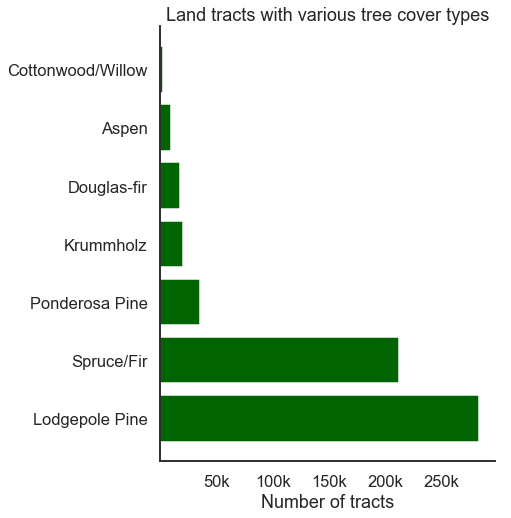

In [83]:
# Plot tree type counts
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,8))
plt.barh(width=[x[1] for x in tree_counts], 
         y=[x[0] for x in tree_counts], 
         color='darkgreen')
plt.yticks(ticks=list(range(0,7)), labels=[x[0] for x in tree_counts])
plt.xticks(ticks=[5e4, 10e4, 15e4, 20e4, 25e4], 
           labels=['50k', '100k', '150k', '200k', '250k'])
plt.xlabel('Number of tracts')
plt.title('Land tracts with various tree cover types')
sns.despine()
plt.savefig('cover_type_counts.png', dpi=300, pad_inches=0.5)
plt.show();

I'm also curious to know how the four wilderness areas compare to one another in size (i.e., number of tracts in the dataset).

In [76]:
# Get wilderness area counts
area_names = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']
wa_counts = [df.loc[:, 'WA_1':'WA_4'].sum()[i] for i in range(4)]
area_counts = sorted(list(zip(area_names, wa_counts)),
                     key=lambda x:x[1], reverse=True)
area_counts

[('Rawah', 260796),
 ('Comanche Peak', 253364),
 ('Cache la Poudre', 36968),
 ('Neota', 29884)]

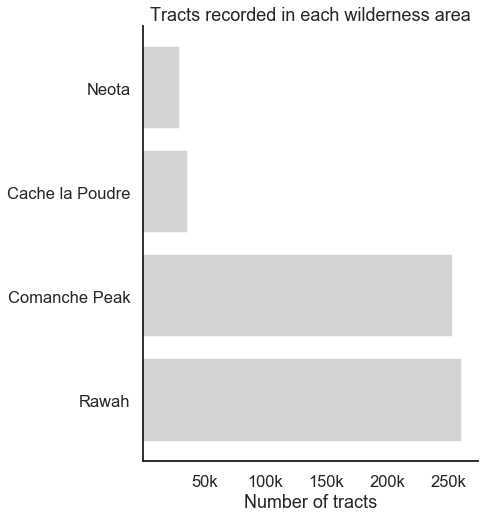

In [85]:
# Plot the tract counts for each wilderness area
plt.figure(figsize=(6,8))
plt.barh(y=[x[0] for x in area_counts], width=[x[1] for x in area_counts],
        color='lightgray')
plt.xticks(ticks=[5e4, 10e4, 15e4, 20e4, 25e4], 
           labels=['50k', '100k', '150k', '200k', '250k'])
plt.xlabel('Number of tracts')
plt.title('Tracts recorded in each wilderness area')
sns.despine()
plt.savefig('area_counts.png', dpi=300, pad_inches=0.5)
plt.show();

I think it's important to get an idea of how each type of tree cover is represented in each wilderness area. Are there some tree cover types that occur only in certain areas? 

In [177]:
# Copy the dataset and add a column for tree cover type names
df_viz = df.copy()
df_viz['tree'] = [tree_dict[i] for i in df_viz['Cover_Type']]
df_viz['tree']

0                  Aspen
1                  Aspen
2         Lodgepole Pine
3         Lodgepole Pine
4                  Aspen
               ...      
581007    Ponderosa Pine
581008    Ponderosa Pine
581009    Ponderosa Pine
581010    Ponderosa Pine
581011    Ponderosa Pine
Name: tree, Length: 581012, dtype: object

In [179]:
# Get counts of each tree type in each area
wa_1_trees = df_viz.groupby('tree')['WA_1'].sum()
wa_2_trees = df_viz.groupby('tree')['WA_2'].sum()
wa_3_trees = df_viz.groupby('tree')['WA_3'].sum()
wa_4_trees = df_viz.groupby('tree')['WA_4'].sum()

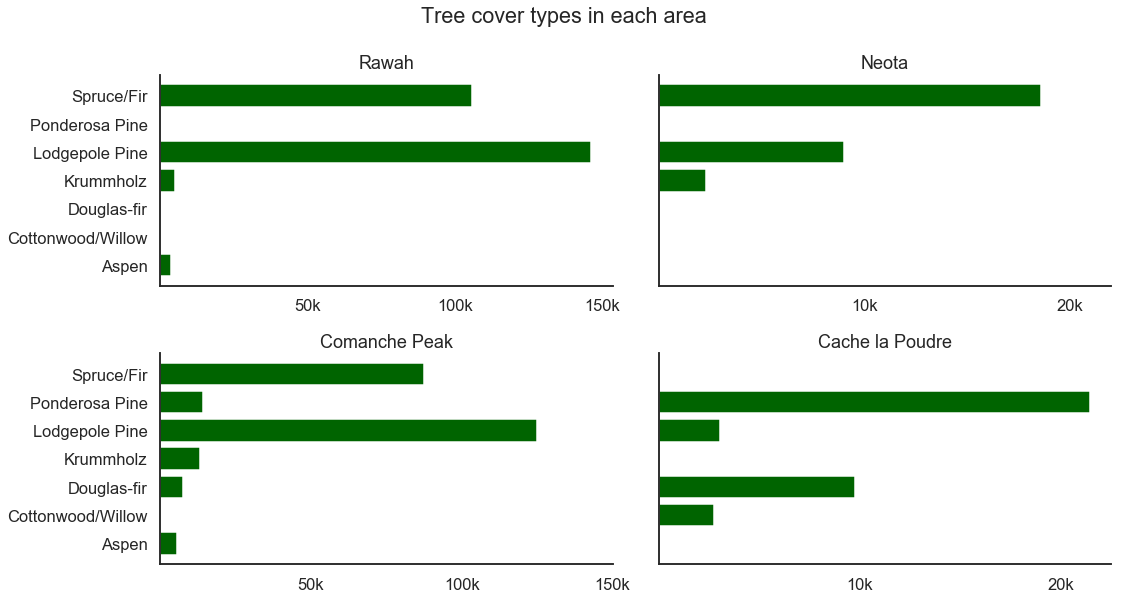

In [180]:
# Plot the tree types per area
areas = [wa_1_trees, wa_2_trees, wa_3_trees, wa_4_trees]
yticks = []
xticks_big = [50000, 100000, 150000]
xtick_labels_big = ['50k', '100k', '150k']
xticks_small = [10000, 20000, 22000]
xtick_labels_small = ['10k', '20k', '']

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(221)
ax1.barh(y=wa_1_trees.index, width=wa_1_trees, color='darkgreen')
ax1.set_title('Rawah')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels)

ax2 = fig.add_subplot(222)
ax2.barh(y=wa_2_trees.index, width=wa_2_trees, color='darkgreen')
ax2.set_title('Neota')
ax2.set_yticks(yticks)
ax2.set_xticks(xticks_small)
ax2.set_xticklabels(xtick_labels_small)

ax3 = fig.add_subplot(223)
ax3.barh(y=wa_3_trees.index, width=wa_3_trees, color='darkgreen')
ax3.set_title('Comanche Peak')
ax3.set_xticks(xticks)
ax3.set_xticklabels(xtick_labels)

ax4 = fig.add_subplot(224)
ax4.barh(y=wa_4_trees.index, width=wa_4_trees, color='darkgreen')
ax4.set_title('Cache la Poudre')
ax4.set_yticks(yticks)
ax4.set_xticks(xticks_small)
ax4.set_xticklabels(xtick_labels_small)

plt.suptitle('Tree cover types in each area', y=1.05)
plt.tight_layout()
sns.despine()
plt.savefig('trees_by_area.png', dpi=300, pad_inches=0.5)

The plots above show that we basically have two large and two small wilderness areas, and each area has a unique distribution of tree types. Rawah, Neota, and Comanche Peak all have Spruce/Fir and Lodgepole Pine as their most common classes, while Cache la Poudre seems to represent a different environment where Ponderosa Pine and Douglas-fir are most common. Knowing how the different types of trees are distributed in each area could help us choose models to use later. For instance, a model that performs well for the three areas with similar tree types might not be such a good choice if we wanted to focus on predictions for Cache la Poudre.

### EDA for modeling

At this early stage, I am concerned about class imbalance, i.e., the possibility that there may be lots of one type of tree cover and few examples of another. This imbalance could cause my machine learning algorithm to find shortcuts to maximizing whatever performance metric we're using, for instance by simply never predicting a rare class.

Let's take a quick look at the counts of each class.

In [8]:
# Check class balance
df.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

As I feared, the classes are very imbalanced: the smallest one is just 1% the size of the largest one! I will address this problem in the section on preprocessing below.

Let's take a look at the continuous variables and see whether they are normally distributed, since non-normal distributions can negatively impact our predictive power.

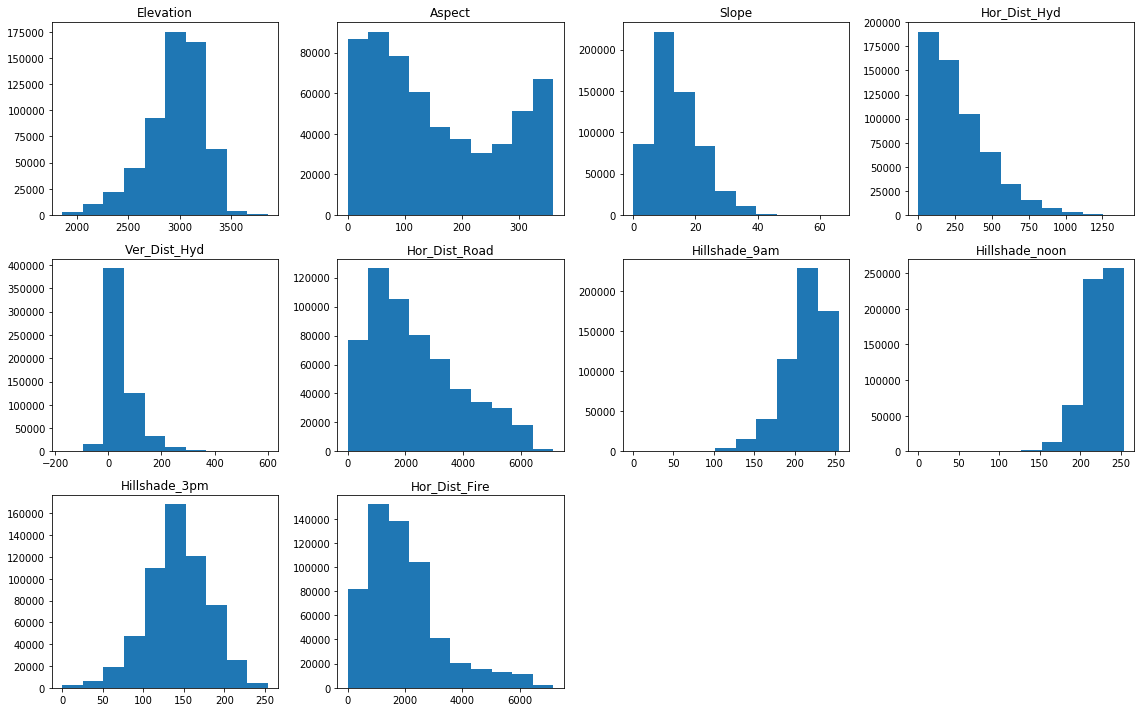

In [9]:
# Visualize distributions of continuous variables
to_hist = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
           'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
           'Hor_Dist_Fire']

plt.figure(figsize=(16,10))
for idx, col in enumerate(to_hist):
    plt.subplot(3, 4, idx+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout();


Some of the continuous variables are skewed right or left, and `Aspect` appears to be bimodal. 

I'm also curious to see whether any of the variables are correlated with one another (and therefore could be eliminated). For instance, there might be a soil type that only occurs in one of the forest preserves. A correlation matrix and heatmap can help us detect this, but it's not a big worry. Principal Components Analysis (below) will help us avoid any repercussions of multicollinearity.

In [10]:
# View correlation matrix
df.corr()

,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
Elevation,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,...,0.167077,0.070633,0.011731,0.083005,0.021107,0.035433,0.217179,0.193595,0.212612,-0.269554
Aspect,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,...,0.056233,0.019163,0.010861,-0.021991,0.002281,-0.020398,0.017706,0.008294,-0.005866,0.017080
Slope,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,...,-0.133504,0.208942,-0.011002,-0.022228,0.002918,0.007848,-0.072208,0.093602,0.025637,0.148285
Hor_Dist_Hyd,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,...,0.127217,0.101195,0.070268,-0.005231,0.033421,-0.006802,0.043031,0.031922,0.147020,-0.020317
Ver_Dist_Hyd,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,...,0.039762,0.167091,0.060274,-0.006092,0.012955,-0.007520,-0.008629,0.043859,0.179006,0.081664
Hor_Dist_Road,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,...,-0.089019,-0.082779,0.006390,-0.003000,0.007550,0.016313,0.079778,0.033762,0.016052,-0.153450
Hillshade_9am,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,...,0.006494,-0.064381,0.007154,0.027870,0.007865,0.010332,0.015108,-0.029620,-0.000016,-0.035415
Hillshade_noon,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329,...,0.125395,-0.086164,0.043061,0.005863,0.016239,-0.022707,0.042952,-0.071961,-0.040176,-0.096426
Hillshade_3pm,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981,...,0.083066,-0.024393,0.017757,-0.016482,0.001330,-0.022064,0.022187,-0.029040,-0.024254,-0.048290
Hor_Dist_Fire,0.148022,-0.109172,-0.185662,0.051874,-0.069913,0.331580,0.132669,0.057329,-0.047981,1.000000,...,-0.089977,-0.059067,-0.035067,-0.000081,-0.010595,0.004180,-0.019740,-0.003301,0.008915,-0.108936


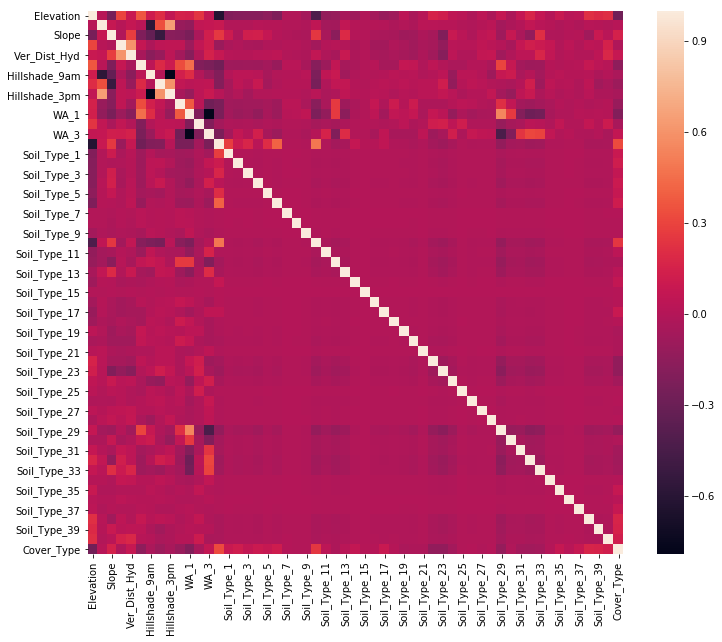

In [11]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr());

It looks like +/-0.7 is about the strongest correlation between any two variables. If it were 0.8, I would be worried about multicollinearity, but I don't think 0.7 poses a real problem. At any rate, the Principal Components Analysis I'll do later will remove any multicollinearity.

I suspect that not all of these features are useful for prediction (especially all those soil types). To test this, I will run a quick Random Forest model and look at the feature importances. If a number of features seem really unimportant for prediction, I can combine/eliminate them using Principal Components Analysis.

In [12]:
# Get a random sample of observations for testing
quick_sample = df.sample(10000, random_state=1)
quick_sample_y = quick_sample['Cover_Type']
quick_sample_x = quick_sample.drop('Cover_Type', axis=1)

# Create and fit a Random Forest classifier to the quick sample data
trial_forest = RandomForestClassifier()
trial_forest.fit(quick_sample_x, quick_sample_y)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.9893


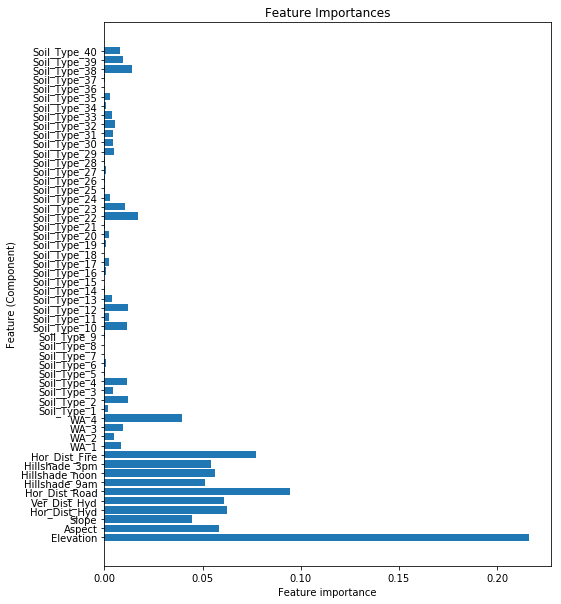

In [13]:
# Visualize the feature importances from the Random Forest trial
print(trial_forest.score(quick_sample_x, quick_sample_y))
n_features = quick_sample_x.shape[1]
plt.figure(figsize=(8,10))
plt.barh(range(n_features), trial_forest.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), quick_sample_x.columns) 
plt.xlabel("Feature importance")
plt.ylabel("Feature (Component)")
plt.title('Feature Importances');

Judging by this quick-and-dirty analysis, there may be about 13-14 features (all of them soil types) that have little importance for prediction. Rather than identify and eliminate them manually, I will use Principal Components Analysis (below) to reduce the dimensions of the dataset to 40.

# Preprocessing

In this section I manipulate the data to prepare it for modeling. There are three main steps I want to take:
- Splitting the data into a training set, a validation set (to help me develop my models), and a test set (to help me evaluate the final version of each model);
- Resampling the training set so that all classes are equally represented;
- Scaling the data, which will help ensure that PCA and some machine learning algorithms work properly;
- and Principal Components Analysis (PCA), which will reduce the dimensions of the data and eliminate any multicollinearity.

I do all these steps first to the training data so that I can check the outcome at each step. Once that's done, I put the essential preprocessing steps into a pipeline that I can use to transform the validation and test sets.

## Train-validation-test split

First up is the train-test split. Note that I am actually making two splits. First, I take 80% of the total dataset to use as my training data. Then I take the remaining 20% of the original dataset and devote half of that to validation and half to be used as a true holdout set, which I will only use to evaluate the final versions of each of my models.

Note also that I am doing stratified splits so that each subset will contain all the classes in the same proportions as in the original dataset.

In [14]:
# Split first into training and test datasets
y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [15]:
# Split again into validation and true holdout (test) datasets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=1,
                                                stratify=y_test)

In [16]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(464809, 54) (464809,)
(58101, 54) (58101,)
(58102, 54) (58102,)


I know that later I will want to compare model performance on the raw data and the preprocessed version, so at this point (before preprocessing) I will save copies for later.

In [17]:
# Save raw copies of train and validation sets before further preprocessing
X_train_raw = X_train.copy()
y_train_raw = y_train.copy()

X_val_raw = X_val.copy()
y_val_raw = y_val.copy()

## Resampling

My next preprocessing step is to deal with the class imbalance. My overall strategy is to undersample the bigger classes and oversample the smaller ones so that every class is the same size as the median-sized class.

First, I'll put the training data back into one DataFrame to make things a little easier.

In [18]:
# Concatenate X_train and y_train for resampling
df_train = pd.concat([X_train, y_train], axis=1)
print(len(df_train))
df_train.head()

464809


,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
450015,3250,35,4,534,212,2969,219,231,148,3161,...,0,0,0,0,0,0,0,0,0,1
127010,2580,61,20,30,-1,1061,232,193,85,553,...,0,0,0,0,0,0,0,0,0,1
247694,2216,41,38,384,251,424,194,129,40,295,...,0,0,0,0,0,0,0,0,0,3
548749,3166,181,17,242,61,3252,224,248,152,630,...,0,0,1,0,0,0,0,0,0,2
29431,2900,296,25,210,92,5076,142,223,218,4763,...,0,0,0,0,0,0,0,0,0,1


Next, let's review the current counts of all the classes.

In [19]:
# Check for class imbalance
df_train.Cover_Type.value_counts()

2    226640
1    169472
3     28603
7     16408
6     13894
5      7594
4      2198
Name: Cover_Type, dtype: int64

Now I can use `RandomUnderSampler` and `SMOTE` to undersample the larger classes and oversample the smaller ones, aiming for every class to have 16,408 observations.

In [20]:
# Randomly undersample the larger classes
rus = RandomUnderSampler(random_state=3, 
                         sampling_strategy={1:16408, 2:16408, 3:16408,})


X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Check class counts
Counter(y_rus)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 2198, 5: 7594, 6: 13894, 7: 16408})

In [21]:
# Randomly oversample the smaller classes
smote = SMOTE(random_state=3, sampling_strategy={4:16408, 5:16408, 6:16408})

X_resampled, y_resampled = smote.fit_resample(X_rus, y_rus)

# Check class counts
Counter(y_resampled)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 16408, 5: 16408, 6: 16408, 7: 16408})

The final count above shows that the classes are now balanced.

## Scaling

The next transformation I want to do is to standardize the features. This isn't required for Random Forests, but it is helpful for more complex algorithms like Support Vector Machines (plus it doesn't hurt Random Forests, so I may as well do it now).

In [22]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled = pd.DataFrame(X_scaled)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# Check the results
X_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,...,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05
mean,2.133063e-16,-3.402508e-18,1.299140e-17,-1.899218e-17,-2.822535e-17,5.765705e-17,3.554693e-16,-5.596817e-16,2.417637e-16,-3.315899e-17,...,-4.008774e-17,5.416175e-17,3.552528e-17,1.082616e-19,-3.181345e-17,-8.966383e-18,2.056971e-17,7.497891e-17,-4.751139e-17,3.136494e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.120858e+00,-1.423987e+00,-1.962208e+00,-1.090620e+00,-3.324786e+00,-1.287201e+00,-6.938578e+00,-7.290815e+00,-2.908838e+00,-1.375326e+00,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
25%,-8.945149e-01,-8.318577e-01,-7.743657e-01,-7.708600e-01,-7.533096e-01,-7.230251e-01,-5.451907e-01,-5.145001e-01,-6.167281e-01,-7.093079e-01,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
50%,1.014521e-02,-2.852769e-01,-1.804444e-01,-2.315627e-01,-3.110812e-01,-3.030859e-01,2.376729e-01,1.455306e-01,7.522952e-02,-2.251362e-01,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
75%,8.544149e-01,9.354203e-01,6.510454e-01,4.843186e-01,4.587237e-01,4.271125e-01,7.595821e-01,7.175571e-01,7.023161e-01,4.305037e-01,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
max,2.655364e+00,1.855498e+00,5.283631e+00,5.509806e+00,8.975714e+00,4.036787e+00,1.346730e+00,1.553596e+00,2.561952e+00,4.988848e+00,...,6.877457e+00,4.662538e+00,4.818818e+00,2.431134e+01,1.178549e+01,4.744553e+01,2.227582e+01,4.446727e+00,4.635722e+00,5.827845e+00


The features have now been standardized so that they all have a mean of 0 and a standard deviation of 1.

Let's just get a quick visual confirmation of this change with some histograms.

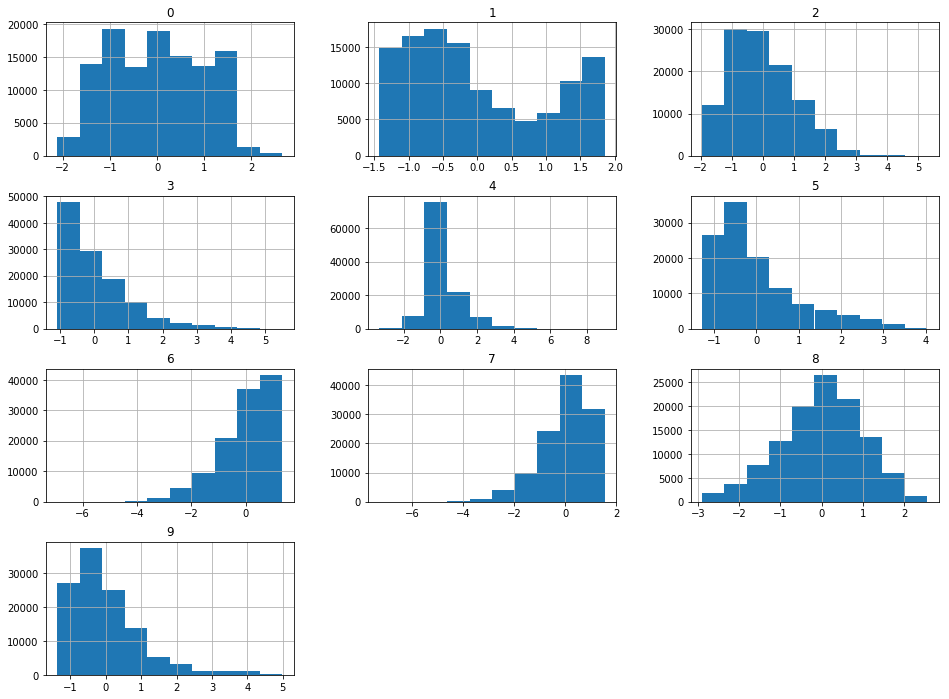

In [24]:
# Visualize the distributions again
X_scaled.loc[:,:9].hist(figsize=(16, 12));

Now that the training data has been scaled, I can move on to PCA.

## PCA

Principal Components Analysis takes the features we have and tries to combine them in ways that maximize the amount of variance the components can explain in the data. For datasets like the one I'm working with here, where there are lots of features, PCA can help us avoid the negative effects of having numerous features while still allowing us to account for as much variance as possible. For my analysis below, I aim to find a number of components that will explain at least 80% of the variance in the data.

First, let's see how much variance we can explain with a wide range of components. If any of these look promising, we can drill down further.

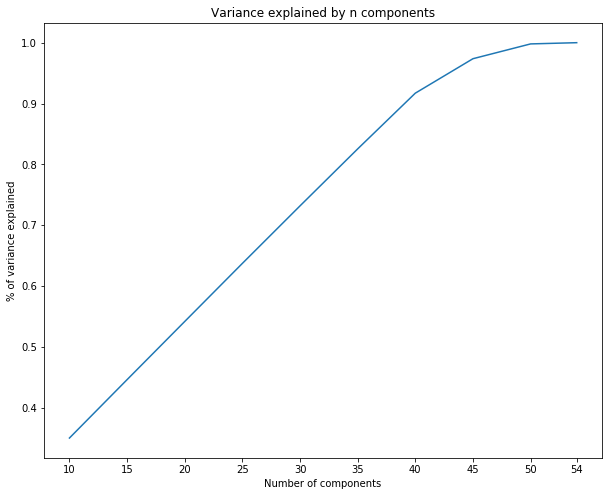

In [25]:
# Try several numbers of components to explain 80% of variance
comps = [10, 15, 20, 25, 30, 35, 40, 45, 50, 54]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X_scaled)
    var_sums.append(np.sum(pca.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50, 54])
plt.show();

Forty components seem to capture about 90% of the variance in the data, which aligns with what we expected based on the feature importances plot above.

Let's check the specifics:

In [26]:
# View the % variance explained for each number of components
display(list(zip(comps, var_sums)))

[(10, 0.35010888736308404),
 (15, 0.44608664619583926),
 (20, 0.5417110272036322),
 (25, 0.6371728315459847),
 (30, 0.731738065646417),
 (35, 0.8253686829453852),
 (40, 0.917027514295714),
 (45, 0.9736568637688149),
 (50, 0.9979901475164933),
 (54, 1.0)]

From the plot and the list above, it's clear that we could explain over 90% of the variance in the data with 40 components (out of a possible 54). Using fewer features/components will help us avoid overfitting on the training data, but at the expense of a little bit of accuracy. I think it's a worthwhile trade.

## Preprocessing pipeline

I know that I want to transform my data so that it is standardized and has 40 components. I will use a pipeline to do this so that I can easily transform my validation and test sets in the same way as my training set without leaking data from one set to another.

In [27]:
# Build a pipeline for the preprocessing steps
pipe_prepro = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(n_components=40))])

I will fit the preprocessing pipeline to the training data (which has been resampled), then use the pipeline to transform the validation and test sets separately.

In [28]:
# Fit the pipeline and transform the training dataset
X_train_trans = pipe_prepro.fit_transform(X_resampled)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
# Use the pipeline to transform the validation and test datasets
X_val_trans = pipe_prepro.transform(X_val)
X_test_trans = pipe_prepro.transform(X_test)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


This transformation will form part of the final pipeline, but by transforming the data now, I can more easily use it to build and evaluate my models.

Finally, I'll just make a copy of my un-preprocessed training labels and give the copy a more convenient name.

In [30]:
# Apply naming conventions to the un-preprocessed labels
y_train_res = y_resampled.copy()

# Testing various algorithms

In the sections that follow I will explore three different algorithms to find one that can classify land tracts by their type of tree cover with the highest accuracy. 

**Random Forest** classifiers use a number of Decision Trees to predict labels for observations. 

**XGBoost** is an ensemble method that trains a series of weak learners to work in sequence to predict labels. This is typically considered a more flexible and powerful type of algorithm than a Random Forest.

**Support Vector Machines** predict labels by drawing decision boundaries between data points in multi-dimensional space. This is considered a very powerful type of classifier, so I'm looking forward to seeing how it performs.

## Random Forest 1

To establish a baseline for all the other models, the first model will be a Random Forest trained on observations that have not been class-balanced, scaled, or transformed with PCA. This is essentially raw data.

### Baseline model

First I will instantiate a Random Forest classifier with default parameters, fit it to the raw training data, and take a look at the accuracy score, confusion matrix, and classification report to see how it performed.

In [45]:
# Fit and score a baseline RandomForestClassifier
forest1 = RandomForestClassifier()
forest1.fit(X_train_raw, y_train_raw)

train_pred = forest1.predict(X_train_raw)

print_metrics(y_train_raw, train_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9978959099328971
-------
Confusion matrix:
[[169269    190      0      0      1      2     10]
 [   409 226215      9      0      2      2      3]
 [     0     30  28556      1      0     16      0]
 [     0      0     14   2181      0      3      0]
 [     2    116      9      0   7467      0      0]
 [     0     24     74      3      0  13793      0]
 [    57      1      0      0      0      0  16350]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    169472
           2       1.00      1.00      1.00    226640
           3       1.00      1.00      1.00     28603
           4       1.00      0.99      1.00      2198
           5       1.00      0.98      0.99      7594
           6       1.00      0.99      1.00     13894
           7       1.00      1.00      1.00     16408

    accuracy                           1.00    464809
   macro avg       1.00      0.99      1.00    464809
weighte

That's an outstanding accuracy score&mdash;and it probably means that the model is overfitting on the training data a bit. 

In [46]:
# Validate
val_pred = forest1.predict(X_val_raw)

print_metrics(y_val_raw, val_pred)

Accuracy: 0.9441489819452333
-------
Confusion matrix:
[[20103  1029     0     0     8     2    42]
 [ 1112 27049    69     1    44    48     7]
 [    0    86  3401     8     2    78     0]
 [    0     0    37   233     0     5     0]
 [   18   241    16     0   671     4     0]
 [    2    68   169     5     3  1489     0]
 [  130    10     0     0     1     0  1910]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.94      0.95      0.94     21184
           2       0.95      0.95      0.95     28330
           3       0.92      0.95      0.94      3575
           4       0.94      0.85      0.89       275
           5       0.92      0.71      0.80       950
           6       0.92      0.86      0.89      1736
           7       0.97      0.93      0.95      2051

    accuracy                           0.94     58101
   macro avg       0.94      0.89      0.91     58101
weighted avg       0.94      0.94      0.94     58101



I'm honestly surprised the model performed this well on the validation data, but it looks like this Random Forest is actually very good at predicting labels for the raw observations.

Next let's see how trying other parameters (not just the defaults) for the Random Forest affects performance.

### Tune parameters with GridSearchCV

A grid search will let me try every possible combination of the parameter values I supply. GridSearchCV performs 3-fold cross-validation on each combination and returns the one that performed the best on average.

For my parameter values, I'm trying 10 v. 100 decision trees; a selection of 30, 40, or all 54 features; and a tree depth of 20 v. 25. Grid searches tend to take a long time to run, so if you're trying to run this code on your own machine, be warned it may take a while!

In [47]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [10, 100],
          'max_features': [30, 40, 54],
          'max_depth': [20, 25]}

grid_forest1 = GridSearchCV(forest1, params, cv=3, n_jobs=-1)

grid_forest1.fit(X_train_raw, y_train_raw)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [50]:
# View best score and parameters
print('Best score:', grid_forest1.best_score_)
print('Best params:', grid_forest1.best_params_)

Best score: 0.9560722791512213
Best params: {'max_depth': 25, 'max_features': 40, 'n_estimators': 100}


The best option found by the grid search had an accuracy score of 95.6% with the parameters listed above.

Now let's examine how the best Random Forest model performs when predicting on the training, validation, and test datasets.

In [51]:
# View training metrics for the best model
y_pred = grid_forest1.predict(X_train_raw)
print_metrics(y_train_raw, y_pred)

Accuracy: 0.9932402341606983
-------
Confusion matrix:
[[167557   1912      0      0      3      0      0]
 [   166 226459      0      0     11      4      0]
 [     0    113  28486      0      0      4      0]
 [     0      0      0   2197      0      1      0]
 [     0    737      1      0   6853      3      0]
 [     0     85      1      0      0  13808      0]
 [    95      6      0      0      0      0  16307]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99    169472
           2       0.99      1.00      0.99    226640
           3       1.00      1.00      1.00     28603
           4       1.00      1.00      1.00      2198
           5       1.00      0.90      0.95      7594
           6       1.00      0.99      1.00     13894
           7       1.00      0.99      1.00     16408

    accuracy                           0.99    464809
   macro avg       1.00      0.98      0.99    464809
weighte

In [52]:
# View validation metrics for the best model
y_pred = grid_forest1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

Accuracy: 0.9638560437858212
-------
Confusion matrix:
[[20228   909     0     0     7     0    40]
 [  452 27769    34     0    38    30     7]
 [    0    55  3457     9     3    51     0]
 [    0     0    31   237     0     7     0]
 [    9   206    16     0   715     4     0]
 [    1    38    74     5     2  1616     0]
 [   65     6     0     0     1     0  1979]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     21184
           2       0.96      0.98      0.97     28330
           3       0.96      0.97      0.96      3575
           4       0.94      0.86      0.90       275
           5       0.93      0.75      0.83       950
           6       0.95      0.93      0.94      1736
           7       0.98      0.96      0.97      2051

    accuracy                           0.96     58101
   macro avg       0.96      0.92      0.93     58101
weighted avg       0.96      0.96      0.96     58101



The optimized Random Forest scored 96% on the validation set. The confusion matrix and classification report show that the model had its worst F1 score for class 5; it seems to be having trouble catching all the instances of that class. We can compare subsequent models to see if any do better at catching that class.

### Evaluating the best (unpreprocessed) Random Forest classifier

So that I don't have to rerun the time-consuming algorithms above, I'll create a pipeline that contains just the model I want, fit it to the raw training data, and then extract predictions for the validation and test sets. This is the first time the model will encounter the test set, so now we'll see how it might perform on unseen data going forward.

In [66]:
# Create and fit the model pipeline
pipe_forest1 = Pipeline([('forest1', RandomForestClassifier(max_depth=25,
                                                            max_features=40,
                                                            n_estimators=100))
                        ])

pipe_forest1.fit(X_train_raw, y_train_raw)

Pipeline(memory=None,
     steps=[('forest1', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [67]:
# View metrics for training data
y_pred = pipe_forest1.predict(X_train_raw)
print_metrics(y_train_raw, y_pred)

Accuracy: 0.9934274078169743
-------
Confusion matrix:
[[167623   1844      0      0      5      0      0]
 [   175 226453      0      0      8      4      0]
 [     0    128  28472      0      0      3      0]
 [     0      0      0   2198      0      0      0]
 [     1    696      2      0   6894      1      0]
 [     0     81      0      0      0  13813      0]
 [   102      5      0      0      0      0  16301]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99    169472
           2       0.99      1.00      0.99    226640
           3       1.00      1.00      1.00     28603
           4       1.00      1.00      1.00      2198
           5       1.00      0.91      0.95      7594
           6       1.00      0.99      1.00     13894
           7       1.00      0.99      1.00     16408

   micro avg       0.99      0.99      0.99    464809
   macro avg       1.00      0.98      0.99    464809
weighte

In [68]:
# View metrics for validation data
y_pred = pipe_forest1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

Accuracy: 0.96466497994871
-------
Confusion matrix:
[[20255   880     0     0     6     0    43]
 [  449 27769    32     0    42    30     8]
 [    0    55  3458    10     3    49     0]
 [    0     0    32   237     0     6     0]
 [    9   192    13     0   731     5     0]
 [    1    37    72     3     2  1621     0]
 [   67     6     0     0     1     0  1977]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.97     21184
           2       0.96      0.98      0.97     28330
           3       0.96      0.97      0.96      3575
           4       0.95      0.86      0.90       275
           5       0.93      0.77      0.84       950
           6       0.95      0.93      0.94      1736
           7       0.97      0.96      0.97      2051

   micro avg       0.96      0.96      0.96     58101
   macro avg       0.96      0.92      0.94     58101
weighted avg       0.96      0.96      0.96     58101



In [69]:
# View metrics for test data
y_pred_test_forest1 = pipe_forest1.predict(X_test)
print_metrics(y_test, y_pred_test_forest1)

Accuracy: 0.9629961102888025
-------
Confusion matrix:
[[20207   935     1     0     6     2    33]
 [  498 27718    44     0    31    28    12]
 [    0    51  3465    16     0    44     0]
 [    0     0    24   240     0    10     0]
 [    5   190     6     0   746     2     0]
 [    0    43    73     5     2  1614     0]
 [   83     6     0     0     0     0  1962]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     21184
           2       0.96      0.98      0.97     28331
           3       0.96      0.97      0.96      3576
           4       0.92      0.88      0.90       274
           5       0.95      0.79      0.86       949
           6       0.95      0.93      0.94      1737
           7       0.98      0.96      0.97      2051

   micro avg       0.96      0.96      0.96     58102
   macro avg       0.96      0.92      0.94     58102
weighted avg       0.96      0.96      0.96     58102



The model's performance on the test dataset is very good&mdash;very close to its score for the validation data. Class 5 is still the one where the model doesn't perform as well, but for every other class, performance is impressive.

One last step to save me time in the future is to "pickle" this model, i.e., save a copy of the model that is already trained and ready to use for prediction.

In [70]:
# Pickle the model
with open('forest1.pickle', 'wb') as f:
    pickle.dump(pipe_forest1, f, pickle.HIGHEST_PROTOCOL)

## Random Forest 2

It's hard to imagine that another model will perform as well as the amazing baseline one above, so from here onward, I'll be looking to see how performance changes for each model. My hope is that I can find another model that performs well where the first one doesn't. This will give me options for predicting under different circumstances or with slightly different goals. 

### Baseline model

In [39]:
# Fit and score a baseline RandomForestClassifier
forest2 = RandomForestClassifier()
forest2.fit(X_train_trans, y_train_res)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
# Evaluate
y_pred = forest2.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.996395486522254
-------
Confusion matrix:
[[16335    42     1     0     3     2    25]
 [  123 16240    12     0    17    12     4]
 [    0     1 16378     6     1    22     0]
 [    0     0     5 16401     0     2     0]
 [    2    16     3     0 16386     1     0]
 [    1     1    62    26     6 16312     0]
 [   14     4     0     0     0     0 16390]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99     16408
           2       1.00      0.99      0.99     16408
           3       0.99      1.00      1.00     16408
           4       1.00      1.00      1.00     16408
           5       1.00      1.00      1.00     16408
           6       1.00      0.99      1.00     16408
           7       1.00      1.00      1.00     16408

    accuracy                           1.00    114856
   macro avg       1.00      1.00      1.00    114856
weighted avg       1.00      1.00      1.00    114856



In [41]:
# Validate 
y_pred = forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.8231183628508976
-------
Confusion matrix:
[[18073  2301    15     0   143    40   612]
 [ 4505 21783   510    12   859   552   109]
 [    2    23  3288    41     9   212     0]
 [    0     0    16   248     0    11     0]
 [   13    40    16     0   872     9     0]
 [    2    14   141    14     4  1561     0]
 [   47     4     0     0     1     0  1999]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.80      0.85      0.82     21184
           2       0.90      0.77      0.83     28330
           3       0.82      0.92      0.87      3575
           4       0.79      0.90      0.84       275
           5       0.46      0.92      0.61       950
           6       0.65      0.90      0.76      1736
           7       0.73      0.97      0.84      2051

    accuracy                           0.82     58101
   macro avg       0.74      0.89      0.80     58101
weighted avg       0.84      0.82      0.83     58101



The Random Forest scored over 99% accuracy on the training set and 82% on the validation set! The Random Forest is probably overfit to the training data. Below I'll use a grid search to see if there are other parameters that would help the Random Forest perform better on the validation set.

For now, let's take a look at the importance the Random Forest assigned to each of the 40 components.

In [42]:
# Check the feature importances
forest2.feature_importances_

array([0.08246777, 0.0129423 , 0.02055541, 0.01996136, 0.01798352,
       0.01533155, 0.04323785, 0.02456184, 0.03054897, 0.0221972 ,
       0.02375608, 0.02463589, 0.0265743 , 0.02289252, 0.02833921,
       0.01738256, 0.02032123, 0.03013794, 0.02742376, 0.02452776,
       0.02466996, 0.02485073, 0.02385575, 0.01269406, 0.02786883,
       0.03020926, 0.02360446, 0.02773516, 0.02613266, 0.01750695,
       0.01378035, 0.02584689, 0.01785867, 0.018686  , 0.02428663,
       0.02286449, 0.04776844, 0.01385219, 0.03033672, 0.00981279])

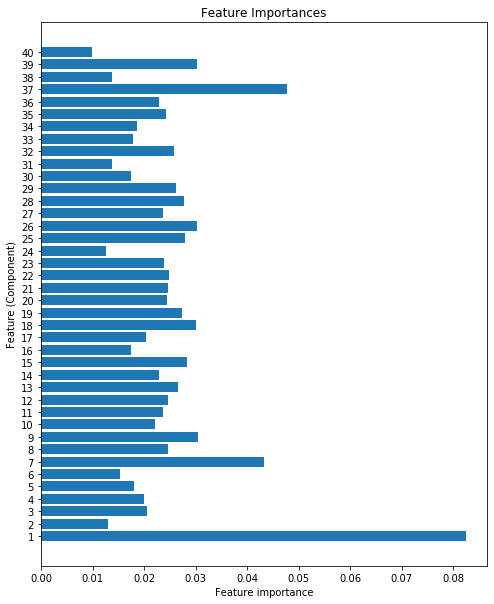

In [44]:
# Visualize feature importances
plot_feature_importances(forest2, X_train_trans)

The plot above shows that there are a few features that are a bit more powerful than the rest. A grid search (below) will help me determine if a different maximum depth of tree or a different number of trees would improve performance.

### Tune parameters with GridSearchCV

In [45]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [100],
          'max_features': [20, 40],
          'max_depth': [20, 25],
          'min_samples_leaf': [5, 10, 20]}

grid_forest2 = GridSearchCV(forest2, params, cv=3, n_jobs=-1)

grid_forest2.fit(X_train_trans, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [46]:
# View best score and parameters
print('Best score:', grid_forest2.best_score_)
print('Best params:', grid_forest2.best_params_)

Best score: 0.8972626593299435
Best params: {'max_depth': 25, 'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 100}


In [47]:
# View the metrics for the best model
y_pred = grid_forest2.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.9730009751340809
-------
Confusion matrix:
[[15566   473     8     0    79    23   259]
 [  404 15314   194     3   266   187    40]
 [    0    19 15878   142    23   346     0]
 [    0     0    28 16368     0    12     0]
 [    6    55    16     0 16305    26     0]
 [    4    25   185   148    29 16017     0]
 [   85    12     0     0     4     0 16307]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     16408
           2       0.96      0.93      0.95     16408
           3       0.97      0.97      0.97     16408
           4       0.98      1.00      0.99     16408
           5       0.98      0.99      0.98     16408
           6       0.96      0.98      0.97     16408
           7       0.98      0.99      0.99     16408

    accuracy                           0.97    114856
   macro avg       0.97      0.97      0.97    114856
weighted avg       0.97      0.97      0.97    114856



In [48]:
# View the metrics for the best model
y_pred = grid_forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.8297103320080549
-------
Confusion matrix:
[[17746  2440    18     0   205    41   734]
 [ 3432 22487   561    12  1101   615   122]
 [    0    15  3226    58    12   264     0]
 [    0     0    20   248     0     7     0]
 [    6    27    15     0   889    13     0]
 [    0    12   101    19     5  1599     0]
 [   36     2     0     0     1     0  2012]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.84      0.84      0.84     21184
           2       0.90      0.79      0.84     28330
           3       0.82      0.90      0.86      3575
           4       0.74      0.90      0.81       275
           5       0.40      0.94      0.56       950
           6       0.63      0.92      0.75      1736
           7       0.70      0.98      0.82      2051

    accuracy                           0.83     58101
   macro avg       0.72      0.90      0.78     58101
weighted avg       0.85      0.83      0.83     58101



### Evaluating the best Random Forest classifier

In [58]:
pipe_forest2 = Pipeline([('scaler', StandardScaler()),
                         ('pca', PCA(n_components=40)),
                         ('forest2', RandomForestClassifier(max_depth=25,
                                                            max_features=20,
                                                            min_samples_leaf=5,
                                                            n_estimators=100))
                        ])
pipe_forest2.fit(X_resampled, y_resampled)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest2', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
       ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [61]:
# View metrics for the optimized model
y_pred = pipe_forest2.predict(X_resampled)
print_metrics(y_resampled, y_pred)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy: 0.9724350491049663
-------
Confusion matrix:
[[15565   472     8     0    84    23   256]
 [  398 15314   197     3   264   193    39]
 [    0    21 15832   147    21   387     0]
 [    0     0    28 16362     0    18     0]
 [    5    56    16     0 16304    27     0]
 [    4    21   191   152    32 16008     0]
 [   87    13     0     0     3     0 16305]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96     16408
           2       0.96      0.93      0.95     16408
           3       0.97      0.96      0.97     16408
           4       0.98      1.00      0.99     16408
           5       0.98      0.99      0.98     16408
           6       0.96      0.98      0.97     16408
           7       0.98      0.99      0.99     16408

   micro avg       0.97      0.97      0.97    114856
   macro avg       0.97      0.97      0.97    114856
weighted avg       0.97      0.97      0.97    114856



In [62]:
# View the metrics for the best model
y_pred = pipe_forest2.predict(X_val)
print_metrics(y_val, y_pred)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy: 0.8313626271492746
-------
Confusion matrix:
[[17803  2405    19     0   194    40   723]
 [ 3420 22537   570    10  1074   603   116]
 [    0    19  3213    60    13   270     0]
 [    0     0    22   246     0     7     0]
 [    6    29    15     0   887    13     0]
 [    0    10    99    18     5  1604     0]
 [   35     2     0     0     1     0  2013]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.84      0.84      0.84     21184
           2       0.90      0.80      0.85     28330
           3       0.82      0.90      0.86      3575
           4       0.74      0.89      0.81       275
           5       0.41      0.93      0.57       950
           6       0.63      0.92      0.75      1736
           7       0.71      0.98      0.82      2051

   micro avg       0.83      0.83      0.83     58101
   macro avg       0.72      0.90      0.78     58101
weighted avg       0.85      0.83      0.84     58101



In [63]:
# Evalutate performance on test data
y_pred_test_forest2 = pipe_forest2.predict(X_test)
print_metrics(y_test, y_pred_test_forest2)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy: 0.8284740628549792
-------
Confusion matrix:
[[17683  2523    19     0   181    40   738]
 [ 3542 22460   585    10  1017   586   131]
 [    0    15  3233    75    11   242     0]
 [    0     0    22   247     0     5     0]
 [    5    33    12     0   896     3     0]
 [    0    13    91    20     6  1607     0]
 [   39     2     0     0     0     0  2010]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83     21184
           2       0.90      0.79      0.84     28331
           3       0.82      0.90      0.86      3576
           4       0.70      0.90      0.79       274
           5       0.42      0.94      0.59       949
           6       0.65      0.93      0.76      1737
           7       0.70      0.98      0.82      2051

   micro avg       0.83      0.83      0.83     58102
   macro avg       0.72      0.90      0.78     58102
weighted avg       0.84      0.83      0.83     58102



In [64]:
# Pickle the model
with open('forest2.pickle', 'wb') as f:
    pickle.dump(pipe_forest2, f, pickle.HIGHEST_PROTOCOL)

## XGBoost

intro

### Baseline model

In [0]:
xg = xgb.XGBClassifier()

In [70]:
xg.fit(X_train_trans, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [71]:
y_pred = xg.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

Accuracy: 0.728294560144877
-------
Confusion matrix:
[[10107  3385     8     0  1033   156  1719]
 [ 3980  8562   371    30  2561   769   135]
 [    0    55 11149  1583   436  3185     0]
 [    0     0   536 15393     2   477     0]
 [  825  1497   550     0 13014   522     0]
 [   69   215  3696  1045   940 10443     0]
 [ 1095   193    12     0   127     0 14981]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.63      0.62      0.62     16408
           2       0.62      0.52      0.56     16408
           3       0.68      0.68      0.68     16408
           4       0.85      0.94      0.89     16408
           5       0.72      0.79      0.75     16408
           6       0.67      0.64      0.65     16408
           7       0.89      0.91      0.90     16408

    accuracy                           0.73    114856
   macro avg       0.72      0.73      0.72    114856
weighted avg       0.72      0.73      0.72    114856



In [72]:
y_pred = xg.predict(X_val_trans)

print_metrics(y_val, y_pred)

Accuracy: 0.579611366413659
-------
Confusion matrix:
[[13029  4347    14     0  1294   199  2301]
 [ 7198 14309   636    57  4470  1394   266]
 [    0    17  2406   340   113   699     0]
 [    0     0    24   240     0    11     0]
 [   54   100    43     0   714    39     0]
 [    5    28   402   106    89  1106     0]
 [  140    23     2     0    14     0  1872]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.76      0.51      0.61     28330
           3       0.68      0.67      0.68      3575
           4       0.32      0.87      0.47       275
           5       0.11      0.75      0.19       950
           6       0.32      0.64      0.43      1736
           7       0.42      0.91      0.58      2051

    accuracy                           0.58     58101
   macro avg       0.46      0.71      0.51     58101
weighted avg       0.67      0.58      0.60     58101



### Tune parameters with GridSearchCV

In [147]:
params = {'learning_rate': [0.01, 0.1],
          'gamma': [0.1, 1],
          'n_estimators': [5, 30, 100],
          'predictor': ['gpu_predictor'],
          'subsample': [0.7]
}

grid_xgb = GridSearchCV(xg, params, scoring='accuracy', cv=3, n_jobs=-1)
grid_xgb.fit(X_train_trans, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': [0.1, 1], 'learning_rate': [0.01, 0.1],
                         'n_estimators': [5, 30, 100],
                         'predictor': ['g

In [148]:
print('Best score:', grid_xgb.best_score_)
print('Best params:', grid_xgb.best_params_)

Best score: 0.7253778644563628
Best params: {'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 100, 'predictor': 'gpu_predictor', 'subsample': 0.7}


In [149]:
y_pred = grid_xgb.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

Accuracy: 0.7306627429128648
-------
Confusion matrix:
[[10305  3207     8     0   978   156  1754]
 [ 4011  8525   363    29  2550   785   145]
 [    0    50 11165  1558   449  3186     0]
 [    0     0   508 15442     2   456     0]
 [  783  1540   552     0 13047   486     0]
 [   51   257  3708  1027   887 10478     0]
 [ 1103   208    13     0   125     0 14959]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.63      0.63      0.63     16408
           2       0.62      0.52      0.56     16408
           3       0.68      0.68      0.68     16408
           4       0.86      0.94      0.90     16408
           5       0.72      0.80      0.76     16408
           6       0.67      0.64      0.66     16408
           7       0.89      0.91      0.90     16408

    accuracy                           0.73    114856
   macro avg       0.73      0.73      0.73    114856
weighted avg       0.73      0.73      0.73    114856



In [150]:
y_pred = grid_xgb.predict(X_val_trans)

print_metrics(y_val, y_pred)

Accuracy: 0.5828643224729351
-------
Confusion matrix:
[[13236  4142    13     0  1242   206  2345]
 [ 7302 14268   630    51  4392  1397   290]
 [    0    16  2416   321   121   701     0]
 [    0     0    24   242     0     9     0]
 [   52    97    44     0   723    34     0]
 [    6    28   405   110    77  1110     0]
 [  139    26     2     0    14     0  1870]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.77      0.50      0.61     28330
           3       0.68      0.68      0.68      3575
           4       0.33      0.88      0.48       275
           5       0.11      0.76      0.19       950
           6       0.32      0.64      0.43      1736
           7       0.42      0.91      0.57      2051

    accuracy                           0.58     58101
   macro avg       0.47      0.71      0.51     58101
weighted avg       0.68      0.58      0.61     58101



### Evaluating the best XGBoost classifier

In [152]:
# Build the optimized model
xgb_best = xgb.XGBClassifier(gamma=1, learning_rate=0.1, n_estimators=100, 
                             predictor='gpu_predictor', subsample=0.7) 
xgb_best.fit(X_train_trans, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7, verbosity=1)

In [153]:
# View metrics for the optimized model
y_pred = xgb_best.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.7306627429128648
-------
Confusion matrix:
[[10305  3207     8     0   978   156  1754]
 [ 4011  8525   363    29  2550   785   145]
 [    0    50 11165  1558   449  3186     0]
 [    0     0   508 15442     2   456     0]
 [  783  1540   552     0 13047   486     0]
 [   51   257  3708  1027   887 10478     0]
 [ 1103   208    13     0   125     0 14959]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.63      0.63      0.63     16408
           2       0.62      0.52      0.56     16408
           3       0.68      0.68      0.68     16408
           4       0.86      0.94      0.90     16408
           5       0.72      0.80      0.76     16408
           6       0.67      0.64      0.66     16408
           7       0.89      0.91      0.90     16408

    accuracy                           0.73    114856
   macro avg       0.73      0.73      0.73    114856
weighted avg       0.73      0.73      0.73    114856



In [154]:
# View full metrics for the validation set
y_val_pred = xgb_best.predict(X_val_trans)
print_metrics(y_val, y_val_pred)

Accuracy: 0.5828643224729351
-------
Confusion matrix:
[[13236  4142    13     0  1242   206  2345]
 [ 7302 14268   630    51  4392  1397   290]
 [    0    16  2416   321   121   701     0]
 [    0     0    24   242     0     9     0]
 [   52    97    44     0   723    34     0]
 [    6    28   405   110    77  1110     0]
 [  139    26     2     0    14     0  1870]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.77      0.50      0.61     28330
           3       0.68      0.68      0.68      3575
           4       0.33      0.88      0.48       275
           5       0.11      0.76      0.19       950
           6       0.32      0.64      0.43      1736
           7       0.42      0.91      0.57      2051

    accuracy                           0.58     58101
   macro avg       0.47      0.71      0.51     58101
weighted avg       0.68      0.58      0.61     58101



In [155]:
# View full metrics for the validation set
y_pred_test_xgb = xgb_best.predict(X_test_trans)
print_metrics(y_test, y_pred_test_xgb)

Accuracy: 0.581150390692231
-------
Confusion matrix:
[[13167  4233    15     0  1304   185  2280]
 [ 7281 14183   662    45  4472  1397   291]
 [    0     7  2442   355    99   673     0]
 [    0     0    17   244     0    13     0]
 [   36    98    50     0   732    33     0]
 [    5    36   397    93    82  1124     0]
 [  151    18     0     0     8     0  1874]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63     21184
           2       0.76      0.50      0.60     28331
           3       0.68      0.68      0.68      3576
           4       0.33      0.89      0.48       274
           5       0.11      0.77      0.19       949
           6       0.33      0.65      0.44      1737
           7       0.42      0.91      0.58      2051

    accuracy                           0.58     58102
   macro avg       0.47      0.72      0.51     58102
weighted avg       0.67      0.58      0.61     58102



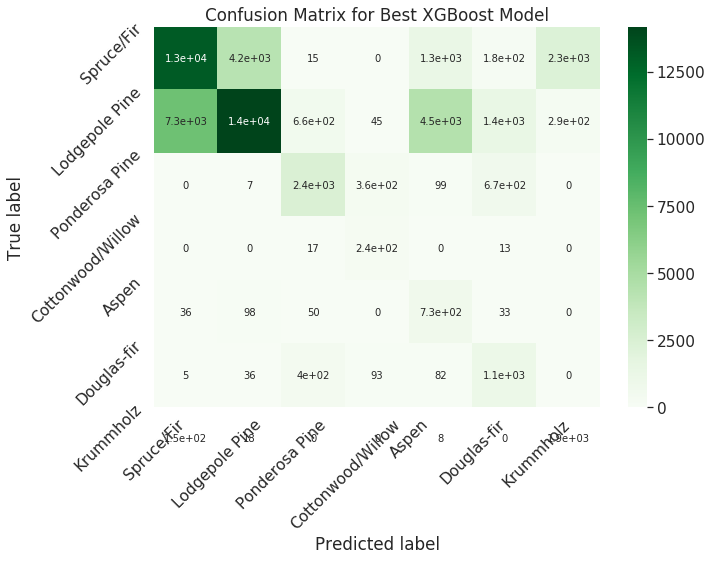

In [175]:
# Display color-coded confusion matrix
pretty_confusion(y_test, y_pred_test_xgb, 'Best XGBoost Model')

In [0]:
# Pickle the model
with open('xgb.pickle', 'wb') as f:
    pickle.dump(xgb_best, f, pickle.HIGHEST_PROTOCOL)

## Support Vector Machine

### Baseline model

In [29]:
# Build a baseline model
svc = SVC(gamma='auto')
svc.fit(X_train_trans, y_train_res)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
y_pred = svc.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.7576530612244898
-------
Confusion matrix:
[[11488  2856    10     0   555   101  1398]
 [ 3497  9629   370    19  2164   587   142]
 [    0   101 10921  1611   424  3351     0]
 [    0     0   547 15439     0   422     0]
 [  238  1460   480     0 13782   448     0]
 [   19   531  3233  1100   331 11194     0]
 [ 1790    41     4     0     5     0 14568]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.67      0.70      0.69     16408
           2       0.66      0.59      0.62     16408
           3       0.70      0.67      0.68     16408
           4       0.85      0.94      0.89     16408
           5       0.80      0.84      0.82     16408
           6       0.70      0.68      0.69     16408
           7       0.90      0.89      0.90     16408

    accuracy                           0.76    114856
   macro avg       0.75      0.76      0.76    114856
weighted avg       0.75      0.76      0.76    114856



In [35]:
y_pred = svc.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.6490249737526033
-------
Confusion matrix:
[[14924  3622    13     0   713   100  1812]
 [ 6236 16322   654    28  3805  1015   270]
 [    0    38  2403   326    94   714     0]
 [    0     0    13   253     0     9     0]
 [   12    95    35     0   766    42     0]
 [    4    51   350   103    21  1207     0]
 [  214     2     0     0     1     0  1834]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.70      0.70      0.70     21184
           2       0.81      0.58      0.67     28330
           3       0.69      0.67      0.68      3575
           4       0.36      0.92      0.51       275
           5       0.14      0.81      0.24       950
           6       0.39      0.70      0.50      1736
           7       0.47      0.89      0.61      2051

    accuracy                           0.65     58101
   macro avg       0.51      0.75      0.56     58101
weighted avg       0.72      0.65      0.67     58101



### Tune parameters with GridSearchCV

In [36]:
params = {'gamma': [0.1, 1.0, 100.0],
          'C': [0.1, 1.0, 10.0]}

grid_svc = GridSearchCV(svc, params, cv=3, scoring='accuracy')
grid_svc.fit(X_train_trans, y_train_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1.0, 10.0], 'gamma': [0.1, 1.0, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [37]:
print('Best score:', grid_svc.best_score_)
print('Best params:', grid_svc.best_params_)

Best score: 0.898385804833879
Best params: {'C': 10.0, 'gamma': 1.0}


In [38]:
y_pred = grid_svc.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.9481002298530333
-------
Confusion matrix:
[[14928  1107     2     0   109    17   245]
 [ 1034 14595   109     0   434   215    21]
 [    0    23 14901   186    75  1223     0]
 [    0     0    26 16337     0    45     0]
 [    6    54    42     0 16263    43     0]
 [    1    33   640   165    37 15532     0]
 [   65     2     0     0     2     0 16339]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.93      0.91      0.92     16408
           2       0.92      0.89      0.91     16408
           3       0.95      0.91      0.93     16408
           4       0.98      1.00      0.99     16408
           5       0.96      0.99      0.98     16408
           6       0.91      0.95      0.93     16408
           7       0.98      1.00      0.99     16408

    accuracy                           0.95    114856
   macro avg       0.95      0.95      0.95    114856
weighted avg       0.95      0.95      0.95    114856



In [39]:
y_pred = grid_svc.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.8303299426860122
-------
Confusion matrix:
[[17906  2418    10     0   192    27   631]
 [ 3624 22431   379     1  1260   518   117]
 [    0    18  3110    52    19   376     0]
 [    0     0    13   253     0     9     0]
 [    0    18    12     0   915     5     0]
 [    1    10   104    18     3  1600     0]
 [   21     1     0     0     1     0  2028]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.83      0.85      0.84     21184
           2       0.90      0.79      0.84     28330
           3       0.86      0.87      0.86      3575
           4       0.78      0.92      0.84       275
           5       0.38      0.96      0.55       950
           6       0.63      0.92      0.75      1736
           7       0.73      0.99      0.84      2051

    accuracy                           0.83     58101
   macro avg       0.73      0.90      0.79     58101
weighted avg       0.85      0.83      0.83     58101



### Evaluating the best Support Vector classifier

In [40]:
# Build the optimized model
svc_best = SVC(C=10, gamma=1)
svc_best.fit(X_train_trans, y_train_res)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [41]:
# View metrics for the optimized model
y_pred = svc_best.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Accuracy: 0.9481002298530333
-------
Confusion matrix:
[[14928  1107     2     0   109    17   245]
 [ 1034 14595   109     0   434   215    21]
 [    0    23 14901   186    75  1223     0]
 [    0     0    26 16337     0    45     0]
 [    6    54    42     0 16263    43     0]
 [    1    33   640   165    37 15532     0]
 [   65     2     0     0     2     0 16339]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.93      0.91      0.92     16408
           2       0.92      0.89      0.91     16408
           3       0.95      0.91      0.93     16408
           4       0.98      1.00      0.99     16408
           5       0.96      0.99      0.98     16408
           6       0.91      0.95      0.93     16408
           7       0.98      1.00      0.99     16408

    accuracy                           0.95    114856
   macro avg       0.95      0.95      0.95    114856
weighted avg       0.95      0.95      0.95    114856



In [42]:
# View full metrics for the validation set
y_val_pred = svc_best.predict(X_val_trans)
print_metrics(y_val, y_val_pred)

Accuracy: 0.8303299426860122
-------
Confusion matrix:
[[17906  2418    10     0   192    27   631]
 [ 3624 22431   379     1  1260   518   117]
 [    0    18  3110    52    19   376     0]
 [    0     0    13   253     0     9     0]
 [    0    18    12     0   915     5     0]
 [    1    10   104    18     3  1600     0]
 [   21     1     0     0     1     0  2028]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.83      0.85      0.84     21184
           2       0.90      0.79      0.84     28330
           3       0.86      0.87      0.86      3575
           4       0.78      0.92      0.84       275
           5       0.38      0.96      0.55       950
           6       0.63      0.92      0.75      1736
           7       0.73      0.99      0.84      2051

    accuracy                           0.83     58101
   macro avg       0.73      0.90      0.79     58101
weighted avg       0.85      0.83      0.83     58101



In [43]:
y_pred_test_svc = svc_best.predict(X_test_trans)
print_metrics(y_test, y_pred_test_svc)

Accuracy: 0.8291280850917352
-------
Confusion matrix:
[[17769  2592    13     0   181    30   599]
 [ 3670 22453   402     2  1187   504   113]
 [    0    13  3135    66    19   343     0]
 [    0     0    17   255     0     2     0]
 [    2    16     8     0   921     2     0]
 [    1     6    96    14    11  1609     0]
 [   19     0     0     0     0     0  2032]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.83      0.84      0.83     21184
           2       0.90      0.79      0.84     28331
           3       0.85      0.88      0.87      3576
           4       0.76      0.93      0.83       274
           5       0.40      0.97      0.56       949
           6       0.65      0.93      0.76      1737
           7       0.74      0.99      0.85      2051

    accuracy                           0.83     58102
   macro avg       0.73      0.90      0.79     58102
weighted avg       0.85      0.83      0.83     58102



In [0]:
# Pickle the model
with open('svc.pickle', 'wb') as f:
    pickle.dump(svc_best, f, pickle.HIGHEST_PROTOCOL)

# Interpretations and recommendations

## Interpretation

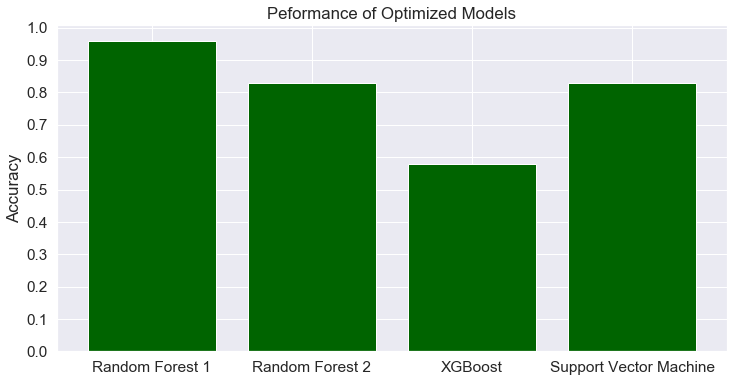

In [71]:
# Plot accuracies of optimized models
best_scores = {'Random Forest 1': .96,
               'Random Forest 2': .83,
               'XGBoost': .58,
               'Support Vector Machine': .83}

plt.figure(figsize=(12,6))
plt.bar(best_scores.keys(), best_scores.values(), color='darkgreen')
plt.yticks(ticks=np.linspace(0,1.0,11))
plt.ylabel('Accuracy')
plt.title('Peformance of Optimized Models')
plt.show();

## Recommendations

## Future work

## Non-technical visualizations

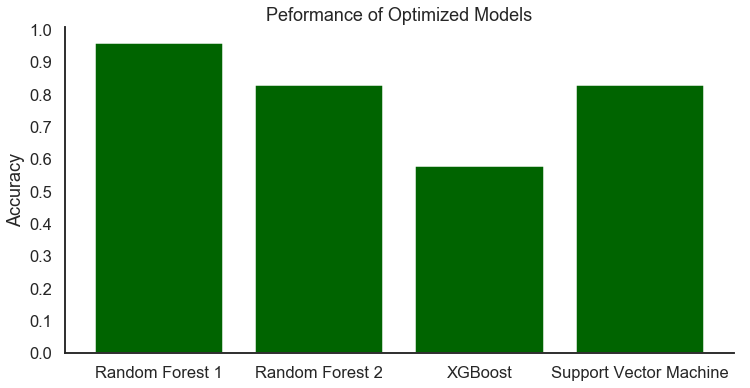

In [82]:
# Plot accuracies of optimized models
best_scores = {'Random Forest 1': .96,
               'Random Forest 2': .83,
               'XGBoost': .58,
               'Support Vector Machine': .83}

plt.figure(figsize=(12,6))
plt.bar(best_scores.keys(), best_scores.values(), color='darkgreen')
plt.yticks(ticks=np.linspace(0,1.0,11))
plt.ylabel('Accuracy')
plt.title('Peformance of Optimized Models')
sns.despine()
plt.savefig('accuracies.png', dpi=300, pad_inches=0.5)
plt.show();

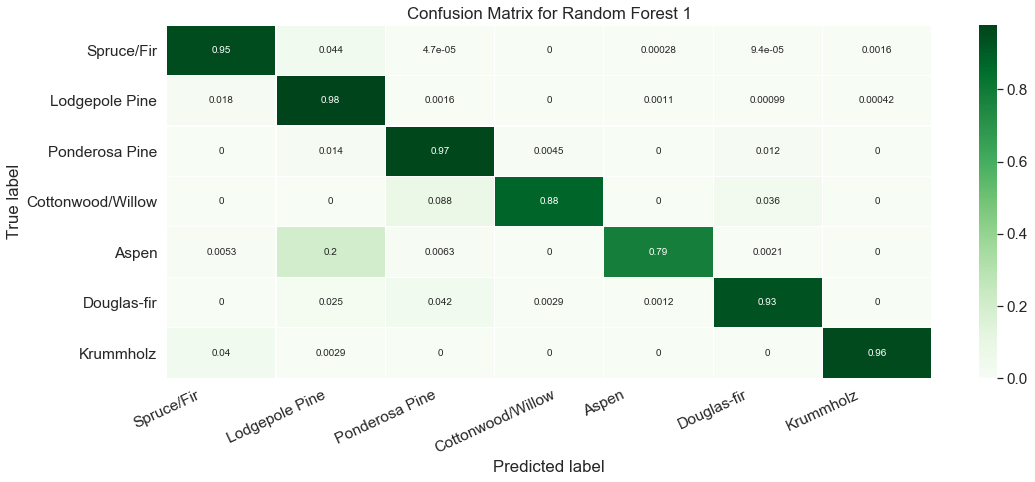

In [79]:
save_conf_matrix(y_test, y_pred_test_forest1, 'Random Forest 1')

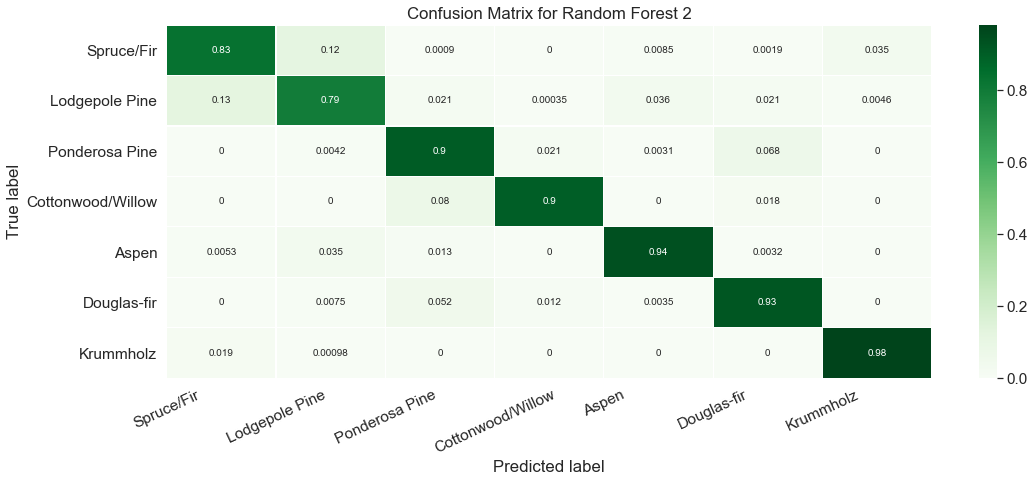

In [73]:
save_conf_matrix(y_test, y_pred_test_forest2, 'Random Forest 2')